In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models # add models to the list
from torchvision.utils import make_grid
import math
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sn
%matplotlib inline

# ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [3]:
train_transform = transforms.Compose([
        transforms.RandomRotation(10),     
        transforms.RandomHorizontalFlip(),
        transforms.Resize((227,227)),
        transforms.ToTensor(),
    ])

test_transform = transforms.Compose([
        transforms.Resize((227,227)),
        transforms.ToTensor(),
    ])

val_transform = transforms.Compose([
        transforms.Resize((227,227)),
        transforms.ToTensor(),
    ])

In [4]:
root = '../chest_xray/'

torch.manual_seed(101)
train_data = datasets.ImageFolder(os.path.join(root, 'train'), transform=train_transform)
test_data = datasets.ImageFolder(os.path.join(root, 'test'), transform=test_transform)
val_data = datasets.ImageFolder(os.path.join(root, 'val'), transform=val_transform)

torch.manual_seed(42)
batch_size = 10
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=len(test_data), shuffle=False)
val_loader = DataLoader(val_data, batch_size=len(val_data), shuffle=False)

train_loader.pin_memory = True
test_loader.pin_memory = True
val_loader.pin_memory = True

class_names = train_data.classes

print(class_names)
print(f'Training images available: {len(train_data)}')
print(f'testing images available:  {len(test_data)}')
print(f'Validation images available:  {len(val_data)}')

['NORMAL', 'PNEUMONIA']
Training images available: 5005
testing images available:  624
Validation images available:  227


In [5]:
class AlexNet(nn.Module):

    def __init__(self, num_classes=2):
        super(AlexNet, self).__init__()
        self.train_losses = []
        self.train_correct = []
        self.val_losses = []
        self.val_correct = []
        self.min_loss = 100
        self.epoch = 0
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [7]:
torch.manual_seed(200)
model = AlexNet().cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [20]:
import time
torch.manual_seed(321)

start_time = time.time()

epochs = 150

# max_trn_batch = 10
# max_val_batch = 2



for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        X_train, y_train = X_train.to(device), y_train.to(device)
        b+=1
        
        # Apply the model
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print interim results
        if b % ((len(train_data)-len(train_data)%10)/batch_size) == 0 or b == (int(len(train_data)/batch_size)):
            print(f'epoch: {model.epoch:2}  batch: {b:4} [{batch_size*b:6}/{len(train_data)}]  loss: {loss.item():10.8f}  \
                    accuracy: {trn_corr.item()*100/(batch_size*b):7.3f}%')

    torch.cuda.empty_cache()
    model.train_losses.append(loss)
    model.train_correct.append(trn_corr)

    # Run the valing batches
    with torch.no_grad():
        loss = 0
        for b, (X_val, y_val) in enumerate(val_loader):
            X_val, y_val = X_val.to(device), y_val.to(device)

            # Apply the model
            y_pred = model(X_val)
            loss += criterion(y_pred, y_val)

            # Tally the number of correct predictions
            predicted = torch.max(y_pred.data, 1)[1] 
            tst_corr += (predicted == y_val).sum()

    print(f'Validation set: loss: {loss.item():10.8f}  \
                    accuracy: {tst_corr.item()*100/(len(val_data)):7.3f}%')
    if loss < model.min_loss:
        torch.save(model, f'AlexnetEpoch{model.epoch}.pt')
        model.min_loss = loss
    model.val_losses.append(loss)
    model.val_correct.append(tst_corr)
    model.epoch += 1
    torch.save(model, f'AlexnetCurrent.pt')
    torch.cuda.empty_cache()

torch.save(model, f'AlexnetFinal.pt')
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch: 50  batch:  500 [  5000/5005]  loss: 0.00941383                      accuracy:  97.440%
Validation set: loss: 0.13625608                      accuracy:  94.273%
epoch: 51  batch:  500 [  5000/5005]  loss: 0.04136456                      accuracy:  97.600%
Validation set: loss: 0.10994878                      accuracy:  95.595%
epoch: 52  batch:  500 [  5000/5005]  loss: 0.10812958                      accuracy:  97.680%
Validation set: loss: 0.07583759                      accuracy:  96.916%
epoch: 53  batch:  500 [  5000/5005]  loss: 0.00547725                      accuracy:  96.380%
Validation set: loss: 0.11223476                      accuracy:  94.273%
epoch: 54  batch:  500 [  5000/5005]  loss: 0.01401275                      accuracy:  96.900%
Validation set: loss: 0.09702544                      accuracy:  96.476%
epoch: 55  batch:  500 [  5000/5005]  loss: 0.07171488                      accuracy:  97.620%
Validation set: loss: 0.05125935                      accuracy:  

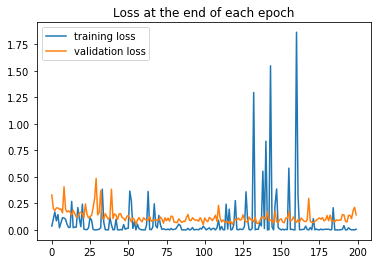

In [21]:
plt.plot(model.train_losses, label='training loss')
plt.plot(model.val_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();
plt.savefig("AlexnetLoss.png")

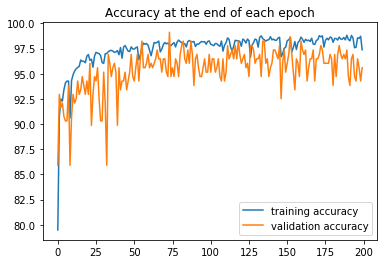

In [22]:
plt.plot([t.item()*100/len(train_data) for t in model.train_correct], label='training accuracy')
plt.plot([t.item()*100/len(val_data) for t in model.val_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();
plt.savefig("AlexnetAcc.png")

In [23]:
with torch.no_grad():
    tst_corr = 0
    for b, (X_test, y_test) in enumerate(test_loader):
        X_test, y_test = X_test.to(device), y_test.to(device)
        y_pred = model(X_test)
        predicted = torch.max(y_pred.data, 1)[1] 
        tst_corr += (predicted == y_test).sum()
print(tst_corr.item()/624*100)

71.7948717948718


In [30]:
model2 = torch.load('AlexnetEpoch99.pt')
# model2= model
# model2.load_state_dict(torch.load('AlexnetEpoch11.pt'))
model2.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

71.7948717948718


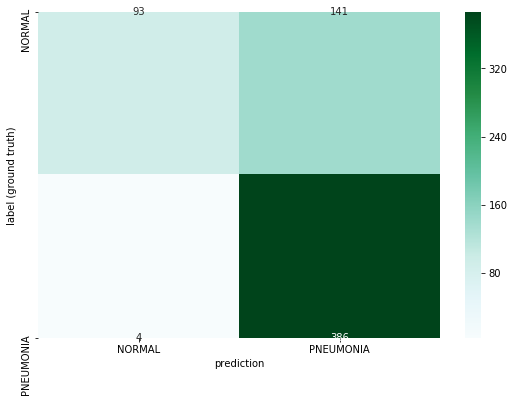

<Figure size 432x288 with 0 Axes>

In [31]:
test_load_all = DataLoader(test_data, batch_size=len(test_data), shuffle=False)

with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        X_test, y_test = X_test.to(device), y_test.to(device)
        y_val = model2(X_test)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()

print(tst_corr.item()/624*100)
arr = confusion_matrix(y_test.view(-1).cpu(), predicted.view(-1).cpu())
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (9,6))
sn.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show();
plt.savefig("AlexnetHeatMap.png")

In [32]:
tn, fp, fn, tp = arr.ravel()
precision = tp/(tp+fp)
recall = tp/(tp+fn)

print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))

Recall of the model is 0.99
Precision of the model is 0.73
